In [1]:
# %load ../kiwi.py
# %load ../env.py
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
#%load_ext rpy2.ipython

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
from rpy2.robjects import r, pandas2ri
import os 
from sklearn.metrics.pairwise import euclidean_distances,manhattan_distances,cosine_similarity

#Set environment variables


# Set up the local source files
#TOP = os.getcwd().replace('notebooks','')
TOP = "/home/ishah/ipynb/Camda18/"

LIB = TOP+'lib'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

os.environ['PYTHONPATH']=LIB


DAT_DIR = TOP + '/data/'
FIG_DIR = TOP + '/figs/'

CMAP_DIR= '/share/home/ishah/projects/HTTR/data/'
CMAP_DAT= '/mnt/data/CMap/CMap2.0/CEL1/'

from db.mongo import *
#DB=openMongo(db='httr_ph1',host='pb.epa.gov')
#DB1=openMongo(db='httr_v1',host='pb.epa.gov')
#MSG=openMongo(db='msigdb_v6',host='pb.epa.gov')
CMP=openMongo(db='cmap_v2',host='localhost')
#CMP = pymongo.MongoClient("mongodb://localhost/cmap_v2")['cmap_v2']
#from gexp.deseq2 import *
pd.options.display.max_colwidth = 500


Populating the interactive namespace from numpy and matplotlib


In [2]:
CMP.collection_names()

[u'chembl_activity',
 u'cmap1',
 u'gene_corr',
 u'chembl_mech',
 u'genes1',
 u'gene_freq',
 u'cmap_fp',
 u'cmap_tgt_new',
 u'cmap_affy_raw',
 u'cmap_fc',
 u'cmap_trt_info',
 u'chembl_mol',
 u'cmap_tgt_b',
 u'cmap_chems',
 u'cmap_dili',
 u'cmap_tgt_a']

In [9]:
CMP.cmap_fp.count()

6100

In [13]:
CMP.cmap_dili.count()

552

In [3]:
def getZVec1(pid,Col,z0,C=['name','cell','pert_id','conc','trt_id']):
    # z0 in 1,2,3
    fpz='fp_z%d' % z0
    X = Col.find_one(dict(pert_id=pid),dict(_id=0))
    FP=X['fp'][fpz]
    Y = {k:X[k] for k in C}
    Y.update({g:+1 for g in FP['up']['ds']})
    Y.update({g:-1 for g in FP['dn']['ds']})
    
    return Y


In [4]:
C1=['name','cell','pert_id','conc','trt_id']
PID= CMP.cmap_dili.distinct('pert_id')
Z2 = (pd.DataFrame(map(lambda i: getZVec1(i,CMP.cmap_fp,z0=2,C=C1),PID))
      .fillna(0)
      .set_index(C1)
     )

In [5]:
Z2.shape

(552, 21692)

In [6]:
N2 = Z2.abs().sum()
N2.shape

(21692,)

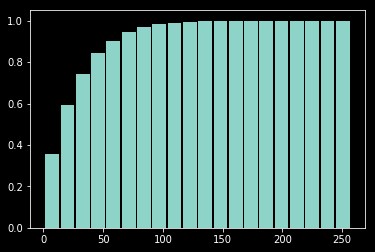

In [18]:
pl.style.use('dark_background')
x = pl.hist(N2,bins=20,rwidth=0.9,cumulative=True,normed=True)

In [19]:
(N2>100).sum()

424

In [60]:
Z2a = Z2[N2[N2>60].index]
Z2a.shape

(552, 2497)

## Link with Dili info

In [61]:
DI0 = pd.DataFrame(list(CMP.cmap_dili.find({},dict(_id=0))))

In [62]:
I1 = list(DI0.columns.intersection(Z2.reset_index().columns))

In [63]:
Z3 = Z2.reset_index().merge(DI0,left_on=I1,right_on=I1)\
    .set_index(['name', 'cell', 'pert_id', 'conc', 'trt_id',
                'data_type','tox'])

## MCF7


In [106]:
Z3a = Z3[N2[N2>20].index]
Z3a.shape

(552, 10769)

In [107]:
Train = Z3a.query("cell=='PC3' and data_type=='Training '")
Valid = Z3a.query("cell=='PC3' and data_type=='Validation'")


In [108]:
X2 = Train.copy()
Y2 = Train.index.get_level_values(6).astype(np.uint)



In [67]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=100.0, random_state=0,verbose=1,learning_rate=10,angle=0.4)
XY=tsne.fit_transform(Z3a) 


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 552 samples in 0.012s...
[t-SNE] Computed neighbors for 552 samples in 0.651s...
[t-SNE] Computed conditional probabilities for sample 552 / 552
[t-SNE] Mean sigma: 9.075144
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.339165
[t-SNE] Error after 1000 iterations: 1.033497


In [68]:
Tox = pd.Series(Z3a.index.get_level_values(6))
Tox.value_counts()
Col = Tox.replace({0:'green',1:'red',np.nan:'gray'})


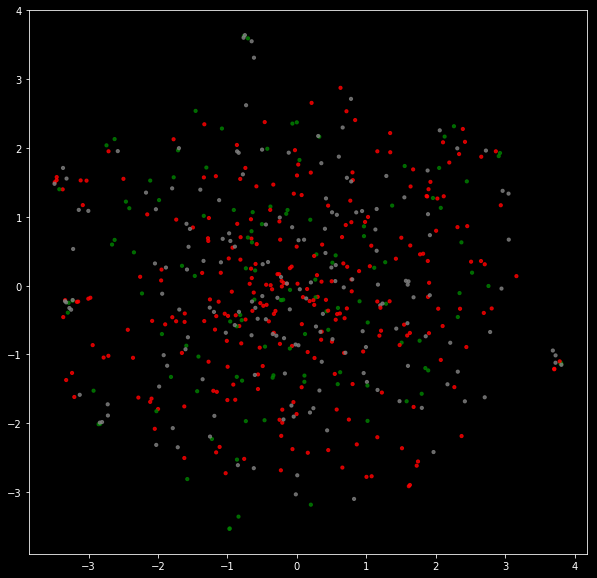

In [69]:
X_loc= pd.DataFrame(XY,index=Z3a.index,columns=['x','y'])
pl.style.use('dark_background')
fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)

ax.scatter(X_loc.x,X_loc.y,c=Col,s=10,alpha=0.8)

## ML


### KNN

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer,f1_score,accuracy_score,precision_score,recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

#KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
#                     metric=’minkowski’, metric_params=None, n_jobs=1)[source]

KNN0 = KNeighborsClassifier(algorithm='auto',metric='euclidean')

params={'n_neighbors': range(1,10),
         'leaf_size': range(5,50,5)
       }

scorers = {
    'f1_score':make_scorer(f1_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

Grid1= GridSearchCV(estimator=KNN0,param_grid=params,
                    n_jobs=-1,cv=StratifiedKFold(Y2,n_folds=3),
                    verbose=1,
                    scoring=make_scorer(f1_score))

In [103]:
Best1=Grid1.fit(X2,Y2)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 12.6min finished


In [91]:
KNN1 = Best1.best_estimator_
Y2p = KNN1.predict(X2)

f1_score(Y2,Y2p),accuracy_score(Y2,Y2p),recall_score(Y2,Y2p),precision_score(Y2,Y2p)


(0.82428115015974435,
 0.71052631578947367,
 0.99230769230769234,
 0.70491803278688525)

In [92]:
Y_pr = pd.DataFrame(KNN1.predict_proba(Valid),columns=['Pr0','Pr1'])
Y_pr['Pred_DILI']=KNN1.predict(Valid)
Y_pr.index=Valid.index
    
DILI0 = pd.concat([pd.read_excel(DAT_DIR+'dili-chemicals-1.xlsx',sheet_name=i) for i in range(3)])
C = [i.lower().replace(' ','_') for i in DILI0.columns]
DILI0.columns=C
DILI0['name']=DILI0.name.str.lower()
P1 = Y_pr.reset_index().merge(DILI0,left_on='name',right_on='name')


### RF

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,f1_score,accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

RF0 = RandomForestClassifier()

params={'min_samples_split': range(2,20,2),
        'min_samples_leaf': range(2,20,2),
         'max_depth': range(2,20,2),
         'n_estimators': range(5,50,5)
       }

def my_f1(y_tr,y_pr):
    return mean_absolute_error(y_tr,y_pr)

f1_scorer = make_scorer(f1_score,greater_is_better=True)
ac_scorer = make_scorer(accuracy_score,greater_is_better=True)
Grid1= GridSearchCV(estimator=RF0,param_grid=params,
                    n_jobs=4,cv=StratifiedKFold(Y2,n_folds=2),
                    verbose=1,
                    scoring=ac_scorer)

In [110]:
Best_RF=Grid1.fit(X2,Y2)

Fitting 2 folds for each of 6561 candidates, totalling 13122 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 11.4min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done 12792 tasks      | elapsed: 17.2min
[Parallel(

In [114]:
#Best_RF.best_score_,Best_RF.best_params_
RF1 = Best_RF.best_estimator_
Y2p = RF1.predict(X2)

f1_score(Y2,Y2p),accuracy_score(Y2,Y2p),recall_score(Y2,Y2p),precision_score(Y2,Y2p)


(0.92418772563176887,
 0.88947368421052631,
 0.98461538461538467,
 0.87074829931972786)

In [115]:
Y_pr = pd.DataFrame(RF1.predict_proba(Valid),columns=['Pr0','Pr1'])
Y_pr['Pred_DILI']=RF1.predict(Valid)
Y_pr.index=Valid.index
    
DILI0 = pd.concat([pd.read_excel(DAT_DIR+'dili-chemicals-1.xlsx',sheet_name=i) for i in range(3)])
C = [i.lower().replace(' ','_') for i in DILI0.columns]
DILI0.columns=C
DILI0['name']=DILI0.name.str.lower()
P1 = Y_pr.reset_index().merge(DILI0,left_on='name',right_on='name')


### Gradient Boosting

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer,f1_score,accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

GBC0 = GradientBoostingClassifier(loss='exponential')

params={'learning_rate': 10**np.linspace(-2,0,num=3),
         'max_depth': range(2,10,2),
         'n_estimators': range(20,50,5)
       }

def my_f1(y_tr,y_pr):
    return mean_absolute_error(y_tr,y_pr)

f1_scorer = make_scorer(f1_score,greater_is_better=True)
ac_scorer = make_scorer(accuracy_score,greater_is_better=True)
Grid1= GridSearchCV(estimator=GBC0,param_grid=params,
                    n_jobs=4,cv=StratifiedKFold(Y2,n_folds=2),
                    verbose=1,
                    scoring=ac_scorer)

In [57]:
Best1=Grid1.fit(X2,Y2)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:  1.6min finished


In [58]:
Best1.best_score_,Best1.best_params_

(0.6894736842105263,
 {'learning_rate': 0.10000000000000001, 'max_depth': 2, 'n_estimators': 30})

In [141]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score

GBC1 = Best1.best_estimator_
Y2p = GBC1.predict(X2)

f1_score(Y2,Y2p),accuracy_score(Y2,Y2p),recall_score(Y2,Y2p),precision_score(Y2,Y2p)


(0.8524590163934427, 0.7631578947368421, 1.0, 0.7428571428571429)

In [148]:
Y_pr = pd.DataFrame(GBC1.predict_proba(Valid),columns=['Pr0','Pr1'])
Y_pr['Pred_DILI']=GBC1.predict(Valid)
Y_pr.index=Valid.index

In [121]:
    
DILI0 = pd.concat([pd.read_excel(DAT_DIR+'dili-chemicals-1.xlsx',sheet_name=i) for i in range(3)])
C = [i.lower().replace(' ','_') for i in DILI0.columns]
DILI0.columns=C
DILI0['name']=DILI0.name.str.lower()
P1 = Y_pr.reset_index().merge(DILI0,left_on='name',right_on='name')
#P1['r'] = P1.Pr1/(1e-5+P1.Pr0)

In [150]:
P1[['name','Pred_DILI','Pr0','Pr1','exp_humans']]

,name,Pred_DILI,Pr0,Pr1,exp_humans
0,acetazolamide,1,0.267709,0.732291,hepatotox
1,alfuzosin,1,0.247107,0.752893,hepatotox
2,ampicillin,1,0.233461,0.766539,hepatotox
3,carisoprodol,1,0.213823,0.786177,non-hepatotox
4,cefepime,1,0.406406,0.593594,non-hepatotox
5,ceftazidime,1,0.350857,0.649143,non-hepatotox
6,chlormezanone,1,0.283020,0.716980,hepatotox
7,chlorpropamide,1,0.233461,0.766539,hepatotox
8,chlorzoxazone,1,0.213823,0.786177,hepatotox
9,dapsone,1,0.268401,0.731599,hepatotox


### KNN 

In [ ]:
from sklearn. import GradientBoostingClassifier
from sklearn.metrics import make_scorer,f1_score,accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

GBC0 = GradientBoostingClassifier(loss='exponential')

params={'learning_rate': 10**np.linspace(-2,0,num=10),
         'max_depth': range(5,10),
         'n_estimators': range(5,105,20)
       }

def my_f1(y_tr,y_pr):
    return mean_absolute_error(y_tr,y_pr)

f1_scorer = make_scorer(f1_score,greater_is_better=True)
ac_scorer = make_scorer(accuracy_score,greater_is_better=True)
Grid1= GridSearchCV(estimator=GBC0,param_grid=params,
                    n_jobs=30,cv=StratifiedKFold(Y2,n_folds=2),
                    verbose=1,
                    scoring=ac_scorer)